In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv('../Andreini_data/data_transformed.csv', index_col=0)
df.index = pd.to_datetime(df.index)
#interpolate gpdc column
df['GDPC1'] = df['GDPC1'].interpolate(method='spline', order=1)
df.head()

,PPIITM,PPICRM,PPICMM,CPIAUCSL,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAS,CPIULFSL,...,UEMP27OV,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USTPU
date,,,,,,,,,,,,,,,,,,,,,
1918-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1918-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1918-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1918-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1918-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


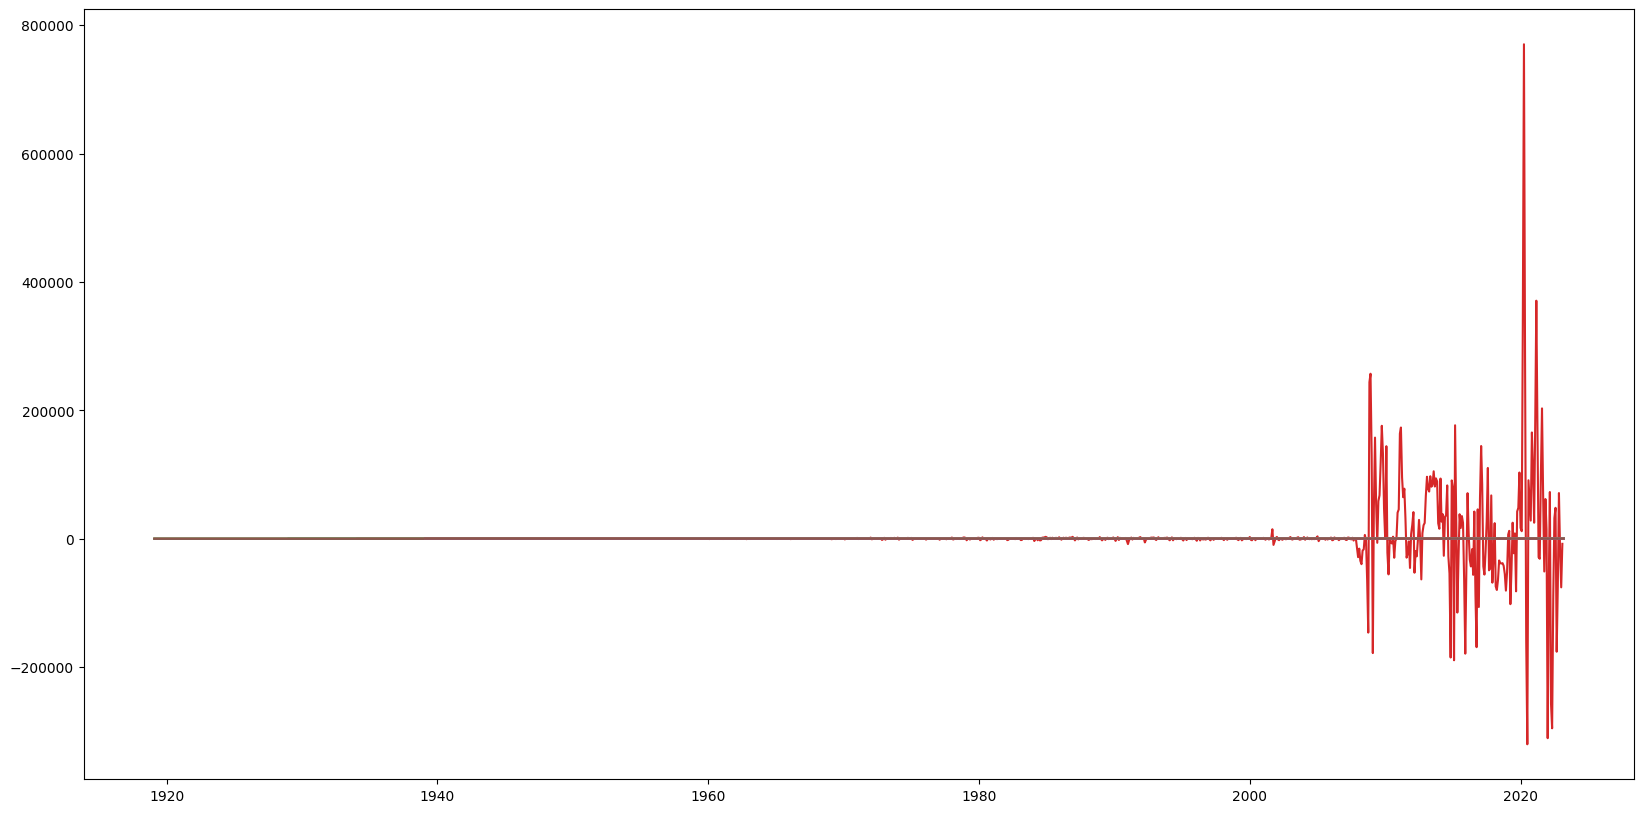

In [212]:
plt.figure(figsize=(20,10))
plt.plot(df);

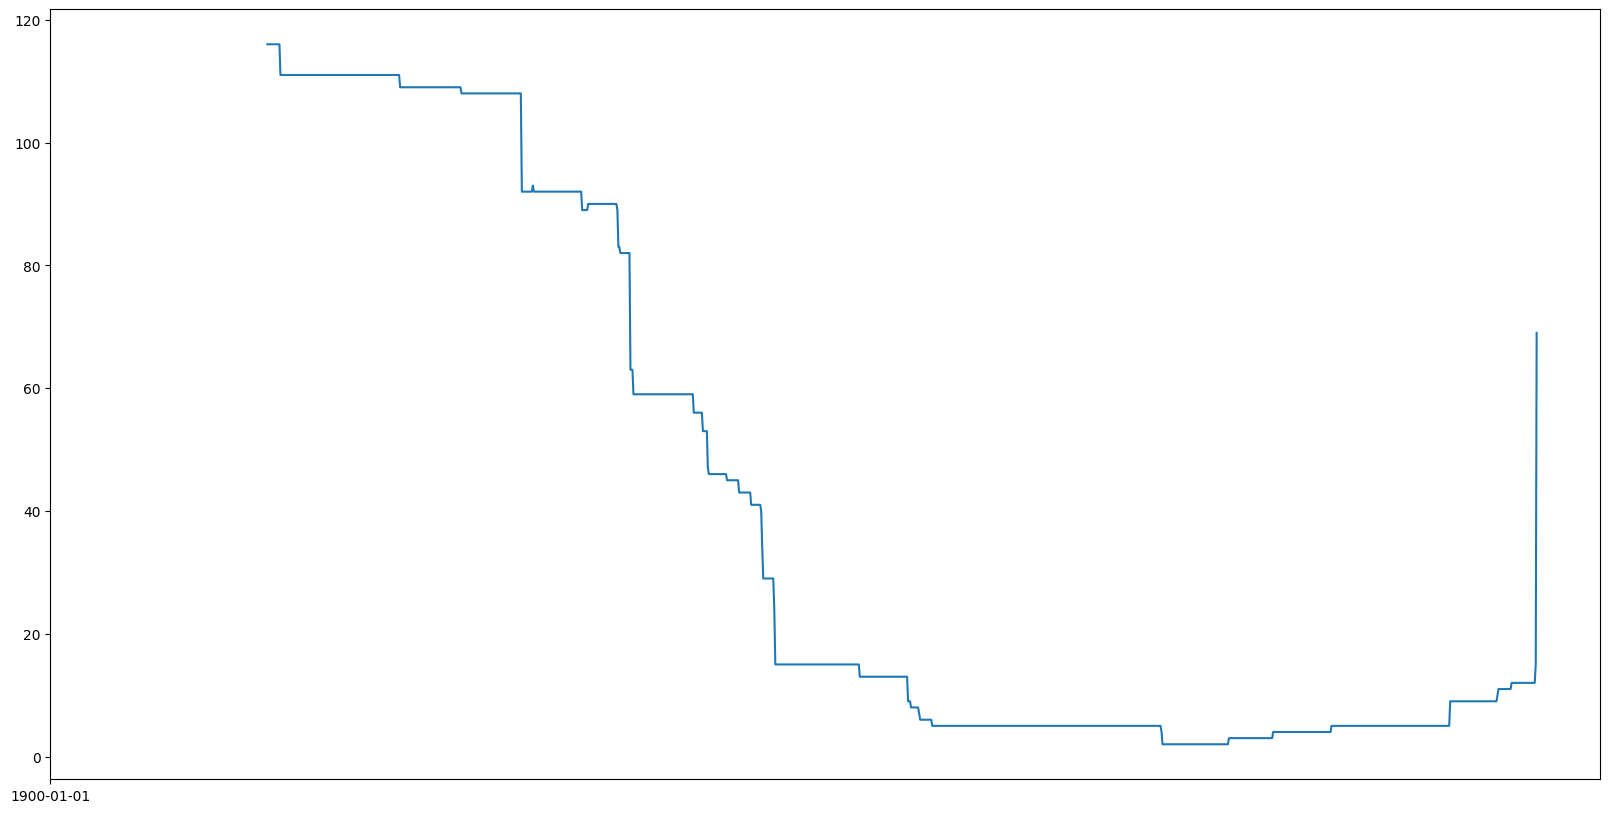

In [213]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df.index, np.isnan(df).sum(axis=1));
ax.set_xticks(ax.get_xticks()[::50]);

529
103


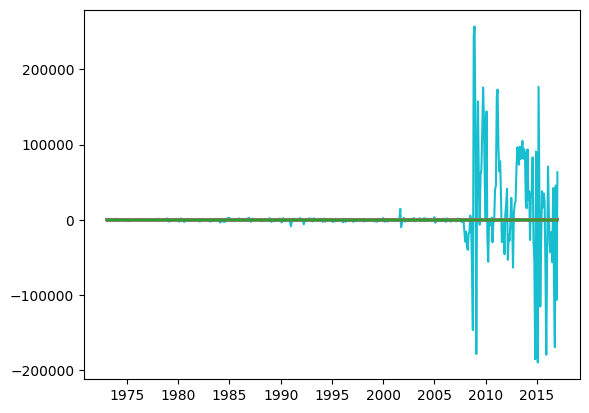

In [214]:
daterange = ['1973-01-01', '2017-01-01']
df = df.loc[daterange[0]:daterange[1]]
df = df.dropna(axis=1, how='any')
print(len(df))
print(len(df.columns))
df.head()
plt.plot(df);

In [56]:
import torch
from torch import nn
import torch.functional as F
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
print(torch.__version__)

class Encoder(nn.Module):
    def __init__(self, hidden_dim: list = [500,200,100], activation: nn.Module = nn.Tanh(), use_batchnorm: bool = True):
        super().__init__()
        self.n_hidden = len(hidden_dim)
        self.hidden_dim: list = hidden_dim
        self.activation: nn.Module = activation
        self.use_batchnorm: bool = use_batchnorm
        self.sequential = self._get_sequential()

    def _get_sequential(self): #compile to nn.Sequential
        res = nn.Sequential()
        for i, lin in enumerate(self.hidden_dim[:-1]):
            res.append(nn.Linear(self.hidden_dim[i],self.hidden_dim[i+1]))
            res.append(self.activation)
            if self.use_batchnorm and i != self.n_hidden-2:
                res.append(nn.BatchNorm1d(self.hidden_dim[i+1]))
        return res

    def forward(self, x):
        out = self.sequential(x)
        return out

class Decoder(nn.Module):
    def __init__(self, linear: bool = False, hidden_dim: list = [100,200,500], activation: nn.Module = nn.Tanh(), use_batchnorm: bool = False):
        super().__init__()
        assert (linear and len(hidden_dim) == 2) or (not linear)
        self.n_hidden = len(hidden_dim)
        self.hidden_dim: list = hidden_dim
        self.activation: nn.Module = activation
        self.use_batchnorm: bool = use_batchnorm
        self.sequential = self._get_sequential()

    def _get_sequential(self): #compile to nn.Sequential
        res = nn.Sequential()
        for i, lin in enumerate(self.hidden_dim[:-1]):
            res.append(nn.Linear(self.hidden_dim[i],self.hidden_dim[i+1]))

            if i < self.n_hidden -2:
                res.append(self.activation)
            if self.use_batchnorm and i < self.n_hidden-2:
                res.append(nn.BatchNorm1d(self.hidden_dim[i+1]))
        return res

    def forward(self, x):
        out = self.sequential(x)
        return out



class AutoEncoder(nn.Module):
    def __init__(self, enc: Encoder, dec: Decoder):
        super().__init__()
        self.enc = enc
        self.dec = dec
        assert dec.hidden_dim[0] == enc.hidden_dim[-1] and dec.hidden_dim[-1] == enc.hidden_dim[0]
    
    def forward(self,x):
        out = self.enc(x)
        out = self.dec(out)
        return out

def train(X: torch.utils.data.DataLoader, model: AutoEncoder, n_epoch:int, optimizer: optim.Optimizer, criterion: nn.Module, lr: float = 0.05):
    """
    Vanilla gradient descent using Adam
    """
    optimizer = optimizer(model.parameters(), lr=lr)
    loss_hist = []
    for epoch in range(n_epoch):
        running_loss = 0.0
        for i, batch in enumerate(X):
            optimizer.zero_grad()
            out = model(batch)
            loss  = criterion(out, batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_hist.append(running_loss/len(X))
        print(f"Epoch {epoch} | {loss_hist[-1]}")
    return loss_hist

2.0.0


## Static autoencoder
### Encode variables into 5 static latent factors

AutoEncoder(
  (enc): Encoder(
    (activation): Tanh()
    (sequential): Sequential(
      (0): Linear(in_features=103, out_features=100, bias=True)
      (1): Tanh()
      (2): Linear(in_features=100, out_features=10, bias=True)
      (3): Tanh()
    )
  )
  (dec): Decoder(
    (activation): Tanh()
    (sequential): Sequential(
      (0): Linear(in_features=10, out_features=100, bias=True)
      (1): Tanh()
      (2): Linear(in_features=100, out_features=103, bias=True)
    )
  )
)
Epoch 0 | 0.34112051129341125
Epoch 1 | 0.31557413935661316
Epoch 2 | 0.2928287088871002
Epoch 3 | 0.270697683095932
Epoch 4 | 0.2480652630329132
Epoch 5 | 0.2248164415359497
Epoch 6 | 0.2013196349143982
Epoch 7 | 0.17810025811195374
Epoch 8 | 0.15568070113658905
Epoch 9 | 0.13452887535095215
Epoch 10 | 0.11505233496427536
Epoch 11 | 0.09757286310195923
Epoch 12 | 0.0822969451546669
Epoch 13 | 0.06930802762508392
Epoch 14 | 0.058563727885484695
Epoch 15 | 0.04990318417549133
Epoch 16 | 0.04307594522833824


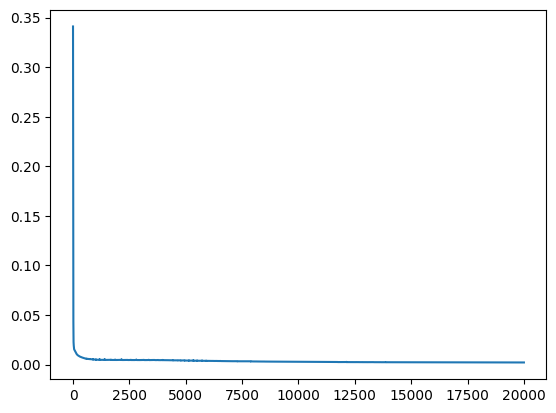

In [216]:
x = df.values
x= (x-x.min(axis=0))/(x.max(axis=0)-x.min(axis=0))
x = torch.from_numpy(x).float()
dataLoader = torch.utils.data.DataLoader(x, batch_size=529, shuffle=False)
input_dim = x.shape[1]
factor_dim = 10
enc = Encoder(hidden_dim = [input_dim, 100, factor_dim], activation=nn.Tanh(), use_batchnorm = False) #fully linear
dec = Decoder(hidden_dim = [factor_dim, 100, input_dim])
model = AutoEncoder(enc, dec)
print(model)
loss_hist = train(X=dataLoader, model=model, n_epoch=20000, optimizer=optim.Adam, criterion=nn.MSELoss(), lr=0.001)
plt.plot(loss_hist)

Text(0.5, 1.0, 'Principal components')

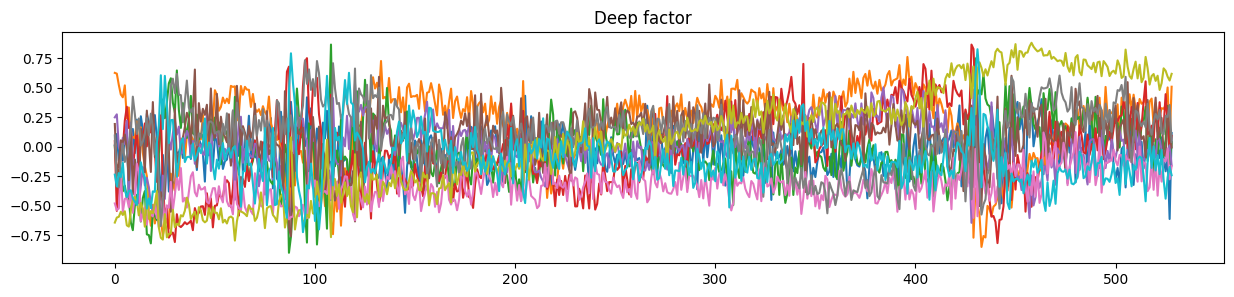

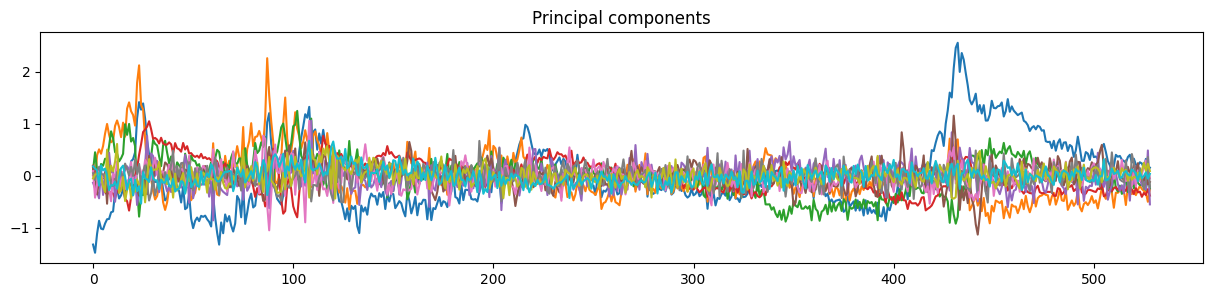

In [217]:
#plot factors
plt.figure(figsize=(15,3))
plt.plot(model.enc(x).detach().numpy());
plt.title('Deep factor')

#compare to PCA
pca = PCA(n_components=factor_dim)
pc = pca.fit_transform(x)
plt.figure(figsize=(15,3))
plt.plot(pc);
plt.title('Principal components')


Text(0.5, 1.0, '$\\hat y$')

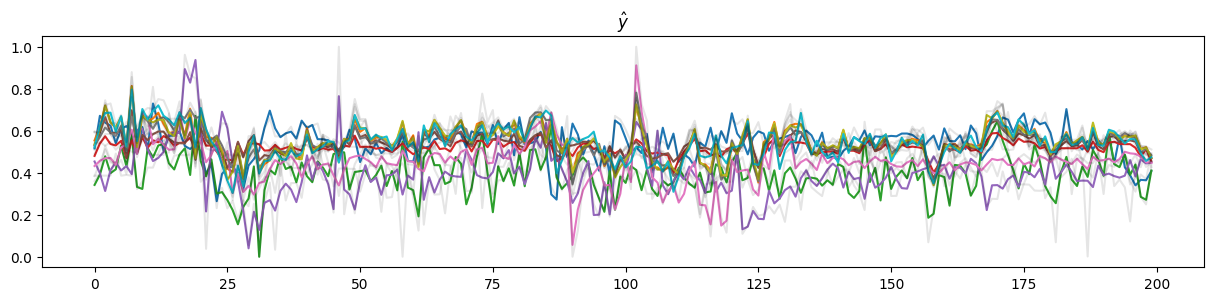

In [218]:
#plot reconstructed y_hat
plt.figure(figsize=(15,3))
y_hat = model(x).detach().numpy()
plt.plot(y_hat[0:200,0:10]);
plt.plot(x[0:200,0:10], color='black', alpha=0.1)
plt.title('$\hat y$')